### SQL-Abfragen in Relationale Algebra konvertieren

Projection
    Selection
        CrossProduct
            ThetaJoin
                Relation
                Relation
            SubqueryScan
                Projection
                    GroupBy
                        ThetaJoin
                            ThetaJoin
                                Relation
                                Relation
                            Relation
π (s.name, e.course)
  <- σ (e.grade = (SELECT MIN(e2.grade) FROM exams AS e2 WHERE s.id = e2.sid))
    <- ⨯
      <- ⋈ ϴ=(s.id = e.sid)
        <- s
        <- e
      <- <<Scalar Subquery Scan>>
        <- π (MIN(e2.grade))
          <- γ (e2.grade: MIN(e2.grade))
            <- ⋈ ϴ=(s.id = e2.sid)
              <- ⋈ ϴ=(s.id = e.sid)
                <- s
                <- e
              <- e2
π (s.name, e.course)
  <- σ (e.grade >= (SELECT AVG(e2.grade) + 1 FROM exams AS e2 WHERE (s.id = e2.sid OR (e2.curriculum = s.major AND s.year > e2.date))))
    <- ⨯
      <- ⋈ ϴ=(s.id = e.sid)
        <- σ ((s.

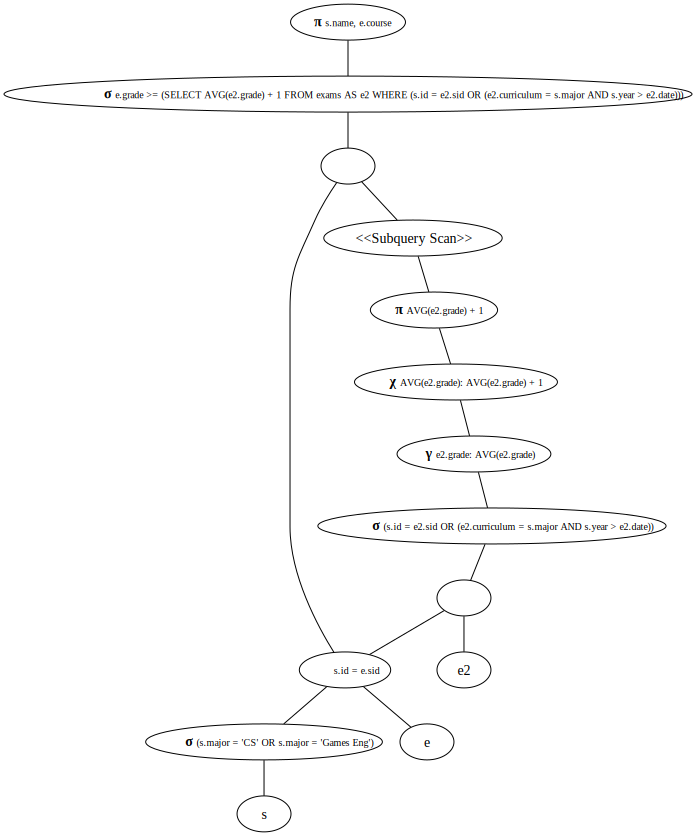

In [1]:
from postbound.vis import optimizer as opt_vis

from src.parser.parser import Parser

parser = Parser()

sql_query_1 = "select s.name,e.course from exams e, students s where s.id = e.sid and e.grade = (select min(e2.grade) from exams e2 where s.id = e2.sid);"

sql_query_2 = "select s.name, e.course from students s, exams e where  s.id=e.sid and (s.major = 'CS' or s.major = 'Games Eng') and e.grade>=(select avg(e2.grade)+1 from exams e2 where s.id=e2.sid or (e2.curriculum=s.major and s.year>e2.date))"

relalg_query_1 = parser.parse_relalg(sql_query_1)
relalg_query_2 = parser.parse_relalg(sql_query_2)

print(parser.str_relalg(relalg_query_1))
print(relalg_query_1.inspect())
print(relalg_query_2.inspect())

opt_vis.plot_relalg(relalg_query_2)

### Optimierung?

[ColumnReference(name='id', table=TableReference(full_name='students', alias='s', virtual=False))]
ThetaJoin
  Predicate: d.id = s.id
  <- ThetaJoin
    Parent: ThetaJoin
    Predicate: s.id = e.sid
    <- Relation
      Parent: ThetaJoin
    <- Relation
      Parent: ThetaJoin
  <- DependentJoin
    Parent: ThetaJoin
    <- Projection
      Parent: DependentJoin
      <- Rename
        Parent: Projection
        <- ThetaJoin
          Parent: Rename
          Predicate: s.id = e.sid
          <- Relation
            Parent: ThetaJoin
          <- Relation
            Parent: ThetaJoin
    <- Projection
      Parent: DependentJoin
      <- GroupBy
        Parent: Projection
        <- ThetaJoin
          Parent: GroupBy
          Predicate: d.id = e2.sid
          <- Relation
            Parent: ThetaJoin
          <- Relation
            Parent: ThetaJoin
⋈ ϴ=(s.id = e.sid)
  <- s
  <- e
π (MIN(e2.grade))
  <- γ (e2.grade: MIN(e2.grade))
    <- ⋈ ϴ=(s.id = e2.sid)
      <- ⋈ ϴ=(s.id =

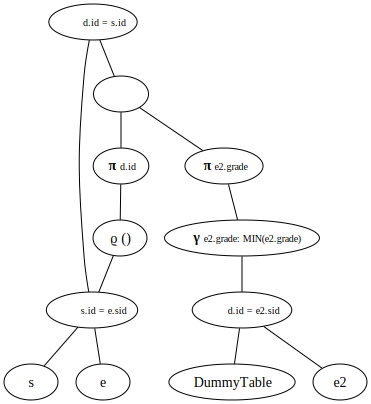

In [5]:
from src.utils.utils import Utils
from src.optimizer.optimizer import Optimizer

optimizer = Optimizer()
t1, t2, dependent_join, d = optimizer.optimize_unnesting(relalg_query_1)

print(t1.inspect())
print(t2.inspect())
print(dependent_join.inspect())
print(d.inspect())
print(t1.tables())

opt_vis.plot_relalg(d)


In [3]:
print(Utils.detailed_structure_visualization(dependent_join))
from postbound.qal import base, predicates, expressions, relalg

tab_r = base.TableReference("R")
tab_s = base.TableReference("S")
col_r_a = base.ColumnReference("a", tab_r)
col_s_a = base.ColumnReference("a", tab_s)
col_r_b = base.ColumnReference("b", tab_r)
col_s_b = base.ColumnReference("b", tab_s)

join_pred_1 = predicates.as_predicate(col_r_a, expressions.LogicalSqlOperators.Equal, col_s_a)
join_pred_2 = predicates.as_predicate(col_r_b, expressions.LogicalSqlOperators.Equal, col_s_b)

# Our old relalg tree: Projection(Select(CrossProduct(R, S)))
scan_r = relalg.Relation(tab_r, [col_r_a])
scan_s = relalg.Relation(tab_s, [col_s_a])
root = relalg.ThetaJoin(scan_r, scan_s, predicates.CompoundPredicate.create_and([join_pred_1, join_pred_2]))

print(root.predicate)
for predicate in root.predicate.base_predicates():
    print(predicate)

DependentJoin
  <- ThetaJoin
    Parent: DependentJoin
    Predicate: s.id = e.sid
    <- Selection
      Parent: ThetaJoin
      Predicate: (s.major = 'CS' OR s.major = 'Games Eng')
      <- Relation
        Parent: Selection
    <- Relation
      Parent: ThetaJoin
  <- Projection
    Parent: DependentJoin
    <- Map
      Parent: Projection
      <- GroupBy
        Parent: Map
        <- Selection
          Parent: GroupBy
          Predicate: (s.id = e2.sid OR (e2.curriculum = s.major AND s.year > e2.date))
          <- Relation
            Parent: Selection
R.a = S.a AND R.b = S.b
R.b = S.b
R.a = S.a


In [4]:
sql_query = "select s.name,e.course from exams e, students s where s.id = e.sid"

relalg_query = parser.parse_relalg(sql_query)
print(relalg_query.inspect())

updated_relalg_query = relalg_query.input_node.mutate(predicate=join_pred_1)
print(updated_relalg_query.parent_node.inspect())



π (s.name, e.course)
  <- ⋈ ϴ=(s.id = e.sid)
    <- s
    <- e
π (s.name, e.course)
  <- ⋈ ϴ=(s.id = e.sid)
    <- s
    <- e
